In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from datetime import date, datetime
import numpy as np
import pandas as pd
import dataframe_image as dfi
pd.options.display.float_format = '{:,.3f}'.format
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()
sns.set_color_codes()
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)

# column_names = ['# Seen', 'ALSA', '# Picked', 'ATA', '# GP', 'GP WR', '# OH', 'OH WR', '# GD', 'GD WR', '# GIH', 'GIH WR', '# GND', 'GND WR', 'IWD', 'Color', 'Rarity']

from Utilities import Logger
import WUBRG
from WUBRG import get_color_identity
from data_graphing.LineColors import LineColors
from game_metadata import SETS, FORMATS
from game_metadata import Card,CardManager, SetMetadata, FormatMetadata
from data_fetching import DataLoader, LoadedData, DataFramer, FramedData, SetManager, CentralManager
from data_fetching.utils import get_next_17lands_update_time, get_prev_17lands_update_time, get_name_slice, get_color_slice, get_date_slice


LOAD_ALL = False
TRGT_SET = 'SNC'
LOG_LEVEL = Logger.FLG.DEFAULT
LOG_LEVEL

<Flags.DEFAULT: 3>

# Objects

In [4]:
import sys
try:
    del sys.modules["data_graphing"] 
    del data_graphing
except:
    pass

from data_graphing import ColorHandler, PlotterHelper, prettify_frame

In [5]:
class FramedDataFuncs:   
    def __init__(self, DATA):
        self._DATA = DATA
        self._ARCH_FUNCS = ArchFuncs(self._DATA)
        self._SNGL_CARD_FUNCS = SingleCardFuncs(self._DATA)
    
    @property
    def SET(self):
        """The draft set."""
        return self._DATA.SET
    
    @property
    def FULL_SET(self):
        """The full name of the draft set."""
        return self._DATA.FULL_SET
    
    @property
    def FORMAT(self):
        """The format type."""
        return self._DATA.FORMAT
    
    @property
    def SHORT_FORMAT(self):
        """The shorthand of the format type."""
        return self._DATA.FULL_FORMAT
    
    @property
    def DATA(self):
        """The object which contains the data about the set and format."""
        return self._DATA
        
    def check_for_updates(self):
        """Populates and updates all data properties, filling in missing data."""
        self._DATA.check_for_updates()

    def reload_data(self):
        """Populates and updates all data properties, reloading all data."""
        self._DATA.reload_data()  
    
    def deck_group_frame(self, name=None, date=None, summary=False):
        """Returns a subset of the 'GROUPED_ARCHETYPE' data as a DataFrame."""
        return self.DATA.deck_group_frame(name, date, summary)
     
    def deck_archetype_frame(self, deck_color=None, date=None, summary=False):
        """Returns a subset of the 'SINGLE_ARCHETYPE' data as a DataFrame."""
        return self.DATA.deck_archetype_frame(deck_color, date, summary)
    
    def card_frame(self, name=None, deck_color=None, date=None, card_color=None, card_rarity=None, summary=False):
        """Returns a subset of the 'CARD' data as a DataFrame."""
        return self.DATA.card_frame(name, deck_color, date, card_color, card_rarity, summary)
    
    def compress_date_range_data(self, start_date, end_date, card_name=None):
        """Summarizes card data over a provided set of time."""
        return self.DATA.compress_date_range_data(start_date, end_date, card_name)
        
    
    #ArchFuncs
    def get_games_played(self, deck_color):
        return self._ARCH_FUNCS.get_games_played(deck_color)
        
    def get_avg_winrate(self, day=None, arch='All Decks'):
        return self._ARCH_FUNCS.get_avg_winrate(day, arch)
    
    def get_archetype_frame(self, colors, roll=None):
        return self._ARCH_FUNCS.get_archetype_frame(colors, roll)

    def get_archetype_winrate_history(self, color_filter=None, roll=None, *, save=False):
        return self._ARCH_FUNCS.get_archetype_winrate_history(color_filter, roll, save=save)

    def plot_archetype_winrate_history(self, color_filter=None, roll=None, color_dict=None, pref=''):
        return self._ARCH_FUNCS.plot_archetype_winrate_history(color_filter, roll, color_dict, pref)       
        
    def get_archetype_playrate_history(self, color_filter=None,  color_count=0, roll=None, *, save=False):
        return self._ARCH_FUNCS.get_archetype_playrate_history(color_filter, color_count, roll, save=save)

    def plot_archetype_playrate_history(self, color_filter=None, color_count=0, roll=None, color_dict=None, pref=''):
        return self._ARCH_FUNCS.plot_archetype_playrate_history(color_filter, color_count, roll, color_dict, pref)
    
    
    #SingleCardFuncs
    def get_card_summary(self, card_name, colors='', roll=None):
        return self._SNGL_CARD_FUNCS.get_card_summary(card_name, colors, roll)

    def plot_card_summary(self, card_name, colors='', roll=None):
        return self._SNGL_CARD_FUNCS.plot_card_summary(card_name, colors, roll)
    
    def get_pick_stats(self, card_name, roll=None):
        return self._SNGL_CARD_FUNCS.get_pick_stats(card_name, roll)
    
    def plot_pick_stats(self, card_name, roll=None):
        return self._SNGL_CARD_FUNCS.plot_pick_stats(card_name, roll)
    
    def card_archetype_performance(self, card_name):
        return self._SNGL_CARD_FUNCS.card_archetype_performance(card_name)
    
    def stat_archetype_performance(self, stat_name, color_cols=None, min_colors=0, max_colors=5):
        return self._SNGL_CARD_FUNCS.stat_archetype_performance(stat_name, color_cols, min_colors, max_colors)

##    # filters = ['exact', 'subset', 'contains', 'adjascent'*]
##    ## TODO: Determine how to handle colourless cards.
##    ## 'exact': 'U' --> 'U'
##    ## 'subset': 'UW' --> 'U', 'W', 'WU'
##    ## 'contains': 'U' --> 'U', 'UW', 'UB', 'UR', 'UG'...
##    ## 'contains': 'UW' --> 'UW', 'UBW', 'URW', 'UGW'...
##    ## 'superset': 'UW' --> 'UW', 'UBW', 'URW', 'UGW'...
##    ## 'adjascent': 'UW' --> 'U', 'W', 'UW', 'UG', 'WG', 'UWG'...
##    def card_color_filter(frame, card_color=None, filter_style=''):
##        if card_color is None: 
##            return frame
##        
##            card_color = WUBRG.get_color_identity(card_color)
##            frame = frame[frame['Color'] == card_color]
##            return frame

    
    def compare_card_evaluations(self, start_date, end_date):
        def inner_func(date):
            df = self.card_frame(date=date, deck_color='')
            df.index = [tup[2] for tup in df.index]
            return df

        first = inner_func(date=start_date)
        last = inner_func(date=end_date)
        diff = last[['ALSA', 'ATA', 'Color', 'Rarity']].copy()
        diff['ALSA Change'] = first['ALSA'] - last['ALSA']
        diff['ATA Change'] = first['ATA'] - last['ATA']
        return diff[['ALSA', 'ALSA Change', 'ATA', 'ATA Change', 'Color', 'Rarity']]


    def get_top(self, column, count=10, asc=True, card_color=None, card_rarity=None, deck_color='', play_lim=None):
        frame = self.card_frame(deck_color=deck_color, summary=True, card_rarity=card_rarity)
        frame = frame.sort_values(column, ascending=asc)

        if card_color is not None:
            card_color = WUBRG.get_color_identity(card_color)
            frame = frame[frame['Color'] == card_color]

        if play_lim is not None:
            #TODO: Fix this. 
            if type(play_lim) is float: play_lim *= self.get_games_played(deck_color)
            print(f'Minimum Games played to be included: {play_lim}')
            frame = frame[frame['# GP'] >= play_lim]

        return frame.head(count)

In [6]:
from data_graphing import ROLL, ARCHETYPES_COLOR_DICT
from WUBRG.consts import COLOR_PAIRS, COLOR_COUNT_REVERSE_MAP, COLOR_COUNT_SHORTHAND, COLOR_COUNT_SHORTHAND_MAP
from WUBRG import COLOUR_GROUPINGS

class ArchFuncs:   
    def __init__(self, DATA):
        self._DATA = DATA
        
    @staticmethod
    def _get_play_stat_frame(frame, col, roll=None):
        #TODO: BE able to filter out splashes.
        if roll is None: roll = ROLL
        ret = frame[[col]]
        ret.reset_index(inplace=True, level=1)
        ret = ret.pivot_table(values=col, index=ret.index, columns='Name', aggfunc=np.sum)
        ret = ret.rolling(window=roll, min_periods=1, center=True).mean().round()
        ret.columns.names = [col]
        return ret

    def _get_all_stat(self, stat, roll=None):
        archetypes = self._get_play_stat_frame(self._DATA.deck_archetype_frame(), stat, roll)
        archetypes = archetypes[[color for color in COLOR_COMBINATIONS if color in archetypes.columns]]

        groups = self._get_play_stat_frame(self._DATA.deck_group_frame(), stat, roll)
        groups.rename(columns=COLOR_COUNT_SHORTHAND_MAP, inplace=True)
        groups = groups[COLOR_COUNT_SHORTHAND]

        return pd.concat([groups, archetypes], axis=1)


    def get_winrates(self, roll=None):
        wins = self._get_all_stat('Wins', roll)
        games = self._get_all_stat('Games', roll)
        frame = (wins / games) * 100
        frame.columns.names = ['Avg. Win %']
        return frame


    def get_playrates(self, num_colors=0, roll=None):
        games = self._get_all_stat('Games', roll)
        
        if num_colors == 0:
            frame = games.div(games['ALL'], axis='rows') * 100
            frame.columns.names = ['% of Decks']
            return frame

        true_name = COLOR_COUNT_REVERSE_MAP[num_colors].title()
        summ_id = COLOR_COUNT_SHORTHAND_MAP[true_name]

        frame = games.div(games[summ_id], axis='rows') * 100
        frame.columns.names = [f'% of {num_colors}C Decks']
        return frame
   
    def get_archetype_winrate_history(self, color_filter=None, roll=None, *, save=False):
        if roll is None: roll = ROLL
            
        frame = self.get_winrates(roll)
        frame.index = [idx[5:] for idx in frame.index]
       
        if isinstance(color_filter, str):
            # TODO: Make this more flexible.
            #col_filt = ['ALL', f'{len(color_filter)}C'] + [col for col in COLOR_PAIRS if color_filter in col]  
            col_filt = ['ALL', '2C'] + [col for col in COLOR_PAIRS if color_filter in col]  
            frame = frame[col_filt]
        elif isinstance(color_filter, list):
            frame = frame[color_filter]
            
        if save:
            PlotterHelper(self._DATA).frame_to_png(frame, "archetype_winrate_table.png")
        
        return frame        
        
    #TODO: Implement a more generic version of this that takes in a list of deck colours to include as output. 
    def get_archetype_playrate_history(self, color_filter=None, color_count=0, roll=None, *, save=False):
        if roll is None: roll = ROLL
            
        frame = self.get_playrates(color_count, roll)
        frame.index = [idx[5:] for idx in frame.index]

        if isinstance(color_filter, str):
            col_filt = [col for col in COLOR_PAIRS if color_filter in col]
            frame = frame[col_filt]
        if isinstance(color_filter, list):
            frame = frame[color_filter]
            
        if save:
            PlotterHelper(self._DATA).frame_to_png(frame, "archetype_playrate_table.png")

        return frame
    
    def plot_archetype_winrate_history(self, color_filter=None, roll=None, color_dict=None, pref=''):
        if roll is None: roll = ROLL
        if color_dict is None: color_dict = ARCHETYPES_COLOR_DICT

        data = self.get_archetype_winrate_history(color_filter, roll)
        colors = str(color_filter)  #TODO: Make this cleverer at showing filter.

        plot_help = PlotterHelper(self._DATA, color_dict=color_dict)
        fig, ax = plot_help.new_single_plot('Archetype Winrates', width=16, height=8)
        plot_help.accredit(y=0.035, x=0.51)
        plot_help.desc_note(colors=colors, roll=roll, y=0.935, x=0.51)
        
        plot_help.set_labels(x_label="Date", y_label="Win Rate")
        plot_help.set_data(data, color_filter)
        
        if not pref:
            plot_help.save_fig(f"win_rates_{roll}day_avg.png", "Metagame")
        else:
            plot_help.save_fig(f"{pref}_win_rates_{roll}day_avg.png", "Metagame")

    def plot_archetype_playrate_history(self, color_filter=None, color_count=0, roll=None, color_dict=None, pref=''):
        if roll is None: roll = ROLL
        if color_dict is None: color_dict = ARCHETYPES_COLOR_DICT
            
        data = self.get_archetype_playrate_history(color_filter, color_count, roll)
        
        
        plot_help = PlotterHelper(self._DATA, color_dict=color_dict)
        fig, ax = plot_help.new_single_plot('Archetype Playrates', width=16, height=8)
        plot_help.accredit(y=0.035, x=0.51)
        plot_help.desc_note(colors=color_filter, roll=roll, y=0.935, x=0.51)
        
        plot_help.set_labels(x_label="Date", y_label="Percent of Metagame")
        plot_help.set_data(data, color_filter)
        
        if not pref:
            plot_help.save_fig(f"play_rates_{roll}day_avg.png", "Metagame")
        else:
            plot_help.save_fig(f"{pref}_play_rates_{roll}day_avg.png", "Metagame")

In [7]:
from data_graphing import ROLL, STATS_COLOR_DICT
from WUBRG import COLOR_COMBINATIONS
from WUBRG.consts import COLOR_PAIRS


class SingleCardFuncs:   
    def __init__(self, DATA):
        self._DATA = DATA
        self._COLOR_IDX = 0
        
    def _shorten_data(self, card_name, roll, cols, colors=''):
        frame = self._DATA.card_frame(name=card_name, deck_color=colors)[cols]
        frame.index = [tup[0][5:] for tup in frame.index]
        rolling = frame.rolling(window=roll, min_periods=1, center=True).mean()
        return rolling

    def plot_card_summary(self, card_name, colors='', roll=None, color_dict=None):
        if roll is None: roll = ROLL
        if color_dict is None: color_dict = STATS_COLOR_DICT
        rolling = self._shorten_data(card_name, roll, ['GIH WR', 'GND WR', 'ATA', 'ALSA', '# GP', '# GIH', '# Picked', '# Seen'], colors=colors)
        if rolling.empty:
            print(f"""Could not find data for "{card_name}". Please make sure it is spelled correctly, or you are accessing the right set.""")
            return
        
        plot_help = PlotterHelper(self._DATA, color_dict=color_dict)
        fig, ax = plot_help.new_quad_plot(card_name)
        plot_help.accredit(y=0.075)
        plot_help.desc_note(colors=colors, roll=roll)
                
        plot_help.set_labels(y_label="Win Percent", g_x=0, g_y=0)
        plot_help.set_data(rolling, ['GIH WR', 'GND WR'], g_x=0, g_y=0)
        
        plot_help.set_labels(y_label="Pick Number", g_x=0, g_y=1)
        plot_help.set_data(rolling, ['ALSA', 'ATA'], inv_y=True, g_x=0, g_y=1)
        
        plot_help.set_labels(x_label="Date", y_label="# of Games", g_x=1, g_y=0)
        plot_help.set_data(rolling, ['# GP', '# GIH'], g_x=1, g_y=0)

        plot_help.set_labels(x_label="Date", y_label="# of Cards", g_x=1, g_y=1)
        plot_help.set_data(rolling, ['# Seen', '# Picked'], g_x=1, g_y=1)
        
        if colors:
            plot_help.save_fig(f"pcs_{card_name}_{colors}.png", "Summary")
        else:
            plot_help.save_fig(f"pcs_{card_name}.png", "Summary")
    
    
    def plot_pick_stats(self, card_name, roll=None, color_dict=None):
        if roll is None: roll = ROLL        
        if color_dict is None: color_dict = STATS_COLOR_DICT
        taken_data = self._shorten_data(card_name, roll, ['ALSA', 'ATA'])
        if taken_data.empty:
            print(f"""Could not find data for "{card_name}". Please make sure it is spelled correctly, or you are accessing the right set.""")
            return
        
        plot_help = PlotterHelper(self._DATA, color_dict=color_dict)
        fig, ax = plot_help.new_single_plot(card_name)
        plot_help.accredit()
        plot_help.desc_note(roll=roll, y=0.96)
        
        plot_help.set_labels(x_label="Date", y_label="Pick Number")
        plot_help.set_data(taken_data, ['ALSA', 'ATA'], inv_y=True)
        
        plot_help.save_fig(f"pps_{card_name}.png", "Pick Stats")


    def card_archetype_performance(self, card_name):
        d = dict()
        d['AVG'] = self._DATA.card_frame(card_name, '', summary=True)
        for col in COLOR_PAIRS:
            d[col] = self._DATA.card_frame(card_name, col, summary=True)

        test_frame = pd.DataFrame.from_dict(d).T
        return test_frame
    
    
    def stat_archetype_performance(self, stat_name, color_cols=None, min_colors=0, max_colors=5):
        series = self._DATA.card_frame(summary=True)[stat_name]
        frame = series.reset_index(level=0)
        ret = pd.pivot_table(frame, index='Name', columns='Deck Colors')
        ret.columns = ret.columns.droplevel(0)
        #ret = ret[COLOR_COMBINATIONS]  #Re-orders the columns in WUBRG order
        if color_cols is not None:
            ret = ret[color_cols]
        return ret

In [38]:
COLOR_COMBINATIONS

['',
 'W',
 'U',
 'B',
 'R',
 'G',
 'WU',
 'WB',
 'WR',
 'WG',
 'UB',
 'UR',
 'UG',
 'BR',
 'BG',
 'RG',
 'WUR',
 'WBR',
 'WBG',
 'UBG',
 'URG',
 'WUB',
 'WUG',
 'WRG',
 'UBR',
 'BRG',
 'WUBR',
 'WUBG',
 'WURG',
 'WBRG',
 'UBRG',
 'WUBRG']

# Initialization

In [8]:
data_manager = None
set_data = None

In [15]:
print(f"Current Local Time:  {datetime.now()}")
print(f"Last 17Lands Update: {get_prev_17lands_update_time()}")
print(f"Current UTC Time:    {datetime.utcnow()}")
print(f"Next 17Lands Update: {get_next_17lands_update_time()}")

Current Local Time:  2022-05-05 23:19:30.771019
Last 17Lands Update: 2022-05-05 02:00:00
Current UTC Time:    2022-05-06 01:49:30.771019
Next 17Lands Update: 2022-05-06 02:00:00


In [17]:
start = datetime.utcnow()

if LOAD_ALL:
    if data_manager is None:
        data_manager = CentralManager()
        SNC = data_manager['SNC']
        NEO = data_manager['NEO']
        VOW = data_manager['VOW']
        MID = data_manager['MID']
        set_data = data_manager[TRGT_SET]
            
    data_manager.check_for_updates()
else:
    if set_data is None:
        set_data = SetManager(TRGT_SET)
    set_data.check_for_updates()

examiner = FramedDataFuncs(set_data.BO1)

end = datetime.utcnow()
print(f"\n --- Data loaded in {end - start}.")

Checking for missing data for SNC PremierDraft...
Finished checking for missing data for SNC PremierDraft.

Checking for missing data for SNC TradDraft...
Finished checking for missing data for SNC TradDraft.

Checking for missing data for SNC QuickDraft...
SNC QuickDraft has no summary data to get!
SNC QuickDraft has no historic data to get!
Finished checking for missing data for SNC QuickDraft.


 --- Data loaded in 0:00:04.893161.


In [10]:
raise Exception('Stopping Auto-Run!')

Exception: Stopping Auto-Run!

# Examine Data

In [ ]:
set_data.BO1.DATA.CARD_SUMMARY_FRAME.loc['']

In [ ]:
examiner.plot_card_summary('Girder Goons')

In [ ]:
examiner.plot_pick_stats('Girder Goons')

In [ ]:
examiner.card_archetype_performance('Girder Goons')

In [ ]:
examiner.stat_archetype_performance('GIH WR', color_cols=['WU', 'WG', 'UB', 'BR', 'RG'])

## Current Tests

In [ ]:
def gt(x, y):  #Used for function pointer shenanigans
    return x > y

def lt(x, y):  #Used for function pointer shenanigans
    return x < y

def filter_quadrant_cards_df(func1, func2, iwd_thresh=0, play_lim=0.01, card_rarity=None, deck_color=''):
    frame = set_data.BO1.card_frame(deck_color=deck_color, summary=True, card_rarity=card_rarity)
    
    # TODO: Make the mean different based on card rarity so cards aren't moved into incorrect categories.
    
    if play_lim is not None:
        if type(play_lim) is float: play_lim *= set_data.BO1.get_games_played(deck_color)
        print(f'Minimum Games played to be included: {play_lim}')
        frame = frame[frame['# GP'] >= play_lim]
        
    games_played_mean = frame['# GP'].mean()
    cards = frame[func1(frame['IWD'], iwd_thresh)]
    cards = cards[func2(cards['# GP'], games_played_mean)]
    cards = cards.sort_values('IWD', ascending=func1==lt)
    return cards


def get_trap_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(lt, gt, iwd_thresh, play_lim, card_rarity, deck_color)

def get_niche_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(gt, lt, iwd_thresh, play_lim, card_rarity, deck_color)

def get_staple_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(gt, gt, iwd_thresh, play_lim, card_rarity, deck_color)

def get_dreg_cards(card_rarity=None, deck_color='', iwd_thresh=0, play_lim=0.01):
    return filter_quadrant_cards_df(lt, lt, iwd_thresh, play_lim, card_rarity, deck_color)

In [ ]:
get_niche_cards(deck_color='GW', card_rarity='CU')

In [ ]:
import functools

@functools.singledispatch
def get_date_slice(arg):
    # By default, if we don't have a special way to handle a parameter, don't change it.
    return arg


@get_date_slice.register(type(None))
def _get_date_slice_none(val):
    # If the parameter is a None, marshall it into a slice.
    return slice(val)


@get_date_slice.register(str)
def _get_date_slice_string(val):
    # If the parameter is a string, marshall it into a single element list to filter properly.
    return [get_color_identity(val)]


@get_date_slice.register(list)
@get_date_slice.register(dict)
@get_date_slice.register(set)
def _get_date_slice_iterable(val):
    # If the parameter is iterable, first convert it to a set to remove duplicates, then handle.
    return [str_date for str_date in val]


@get_date_slice.register(tuple)
def _get_date_slice_range(val):
    # If the parameter is iterable, check if it should be a range.
    if len(val) == 2:
        # If it should be a range, get the colours check that the colours elements are properly ordered.
        str_date1 = val[0]
        str_date2 = val[1]
        return slice(col1, col2)
        
        # TODO: Check date ordering
        # Then make sure a valid range is returned.
        if color_compare(col2, col1) == 1:
            return slice(col1, col2)
        else:
            # TODO: See if returning a reversed range is possible.
            return slice(col2, col1)
    else:
        # If not, handle it like as an iterable.
        return _get_date_slice_iterable(val)

In [ ]:
set_data.BO1.DATA.SINGLE_ARCHETYPE_SUMMARY_FRAME.loc[['W']]

In [ ]:
from data_fetching.utils.index_slice_helper import get_name_slice, get_color_slice

In [ ]:
set_data.BO1.DATA.CARD_HISTORY_FRAME.loc[slice('2022-04-29', '2022-05-01'), get_color_slice(''), get_name_slice({'Girder Goons', 'Angelic Observer', 'A Little Chat', 'Case the Joint'})]

In [ ]:
data = set_data.BO1.DATA.CARD_HISTORY_FRAME.loc(axis=0)[pd.IndexSlice[slice(None), get_color_slice(''), get_name_slice(None)]]
cheap = data[data['CMC'] <= 3]
expensive = data[data['CMC'] >= 5]

In [ ]:
cheap['Games Won'] = cheap['# GIH'] * cheap['GIH WR'] * 0.01
cheap_sums = cheap[['# GP', '# GIH', 'Games Won']].sum()
cheap_wr = cheap_sums['Games Won'] / cheap_sums['# GIH']
cheap_wr

In [ ]:
expensive['Games Won'] = expensive['# GIH'] * expensive['GIH WR'] * 0.01
expensive_sums = expensive[['# GP', '# GIH', 'Games Won']].sum()
expensive_wr = expensive_sums['Games Won'] / expensive_sums['# GIH']
expensive_wr

In [ ]:
for i in range(0, 9):
    by_cmc = data[data['CMC'] == i]
    by_cmc['Games Won'] = by_cmc['# GIH'] * by_cmc['GIH WR'] * 0.01
    sums = by_cmc[['# GP', '# GIH', 'Games Won']].sum()
    avg = by_cmc[['GIH WR']].mean()['GIH WR']
    wr = sums['Games Won'] / sums['# GIH'] * 100
    print(f"CMC: {i}, WR: {wr}  AVG: {avg}")

# TODO

- Calculate archetype openess
 - GIH WR & ALSA based
 - 2.25 of a common per draft 
- Improve graphing capabilities
 - Modify Graphs so they also save an image to a cache folder.
 - Implement better graph titles and axes
 - Update functions to be more general, and have DataFrames piped into them.
- Move sets of files into subfolders based on functionality and relationship (DataFetch, Cards, Graphing, Utils, etc.)
- Better group settings and consts into one file/location.

# Data Graphing and Display

## Card Summary

In [ ]:
examiner.plot_card_summary('Jewel Thief')

In [ ]:
examiner.plot_card_summary('Disciplined Duelist')

In [13]:
examiner.get_top('GIH WR', count=25, asc=False, deck_color='', card_color=None, card_rarity='C', play_lim=0.005)

AttributeError: 'ArchFuncs' object has no attribute 'get_games_played'

Plotting "Murder"...     Done!
Plotting "Strangle"...     Done!
Plotting "Hold for Ransom"...     Done!
Plotting "Run Out of Town"...     Done!
Plotting "Make Disappear"...     Done!
Plotting "Witness Protection"...     Done!
Plotting "Sleep with the Fishes"...     Done!
Plotting "Strangle"...     Done!
Plotting "Body Dropper"...     Done!
Plotting "Celestial Regulator"...     Done!
Plotting "Civil Servant"...     Done!
Plotting "Jetmir's Fixer"...     Done!
Plotting "Snooping Newsie"...     Done!
Plotting "Body Dropper"...     Done!
Plotting "Celestial Regulator"...     Done!
Plotting "Civil Servant"...     Done!
Plotting "Jetmir's Fixer"...     Done!
Plotting "Snooping Newsie"...     Done!
Plotting "Spara's Adjudicators"...     Done!
Plotting "Glamorous Outlaw"...     Done!
Plotting "Rakish Revelers"...

C:\Users\Zachary\Coding\GitHub\DraftMetaReporter\data_graphing\PlotterHelper.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.FIG, self.AX = plt.subplots(2, 2)


     Done!
Plotting "Masked Bandits"...     Done!
Plotting "Shattered Seraph"...     Done!
Plotting "Inspiring Overseer"...     Done!
Plotting "Raffine's Informant"...     Done!
Plotting "Gathering Throng"...     Done!
Plotting "Jewel Thief"...     Done!
Plotting "Echo Inspector"...     Done!
Plotting "Girder Goons"...     Done!
Plotting "Dapper Shieldmate"...     Done!
Plotting "Corrupt Court Official"...     Done!
Plotting "Caldaia Strongarm"...     Done!
Plotting "Backup Agent"...     Done!
Plotting "Mayhem Patrol"...     Done!


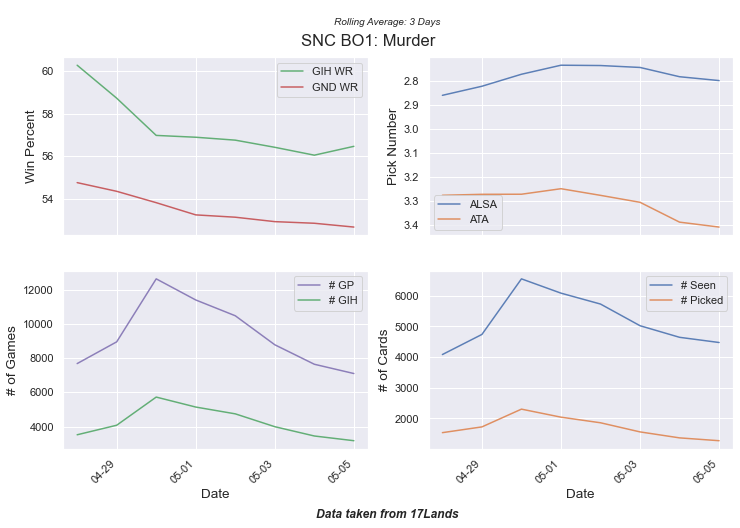

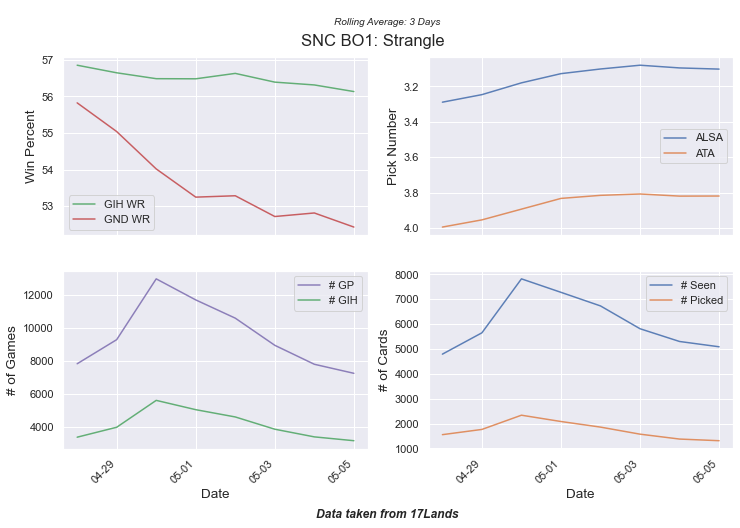

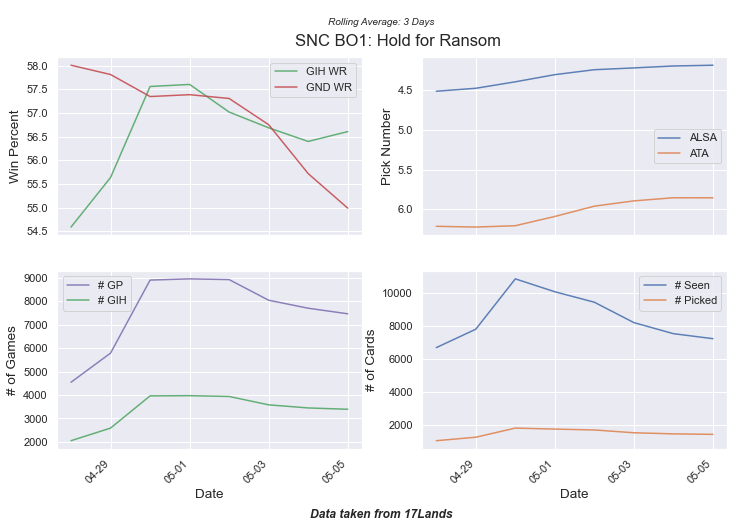

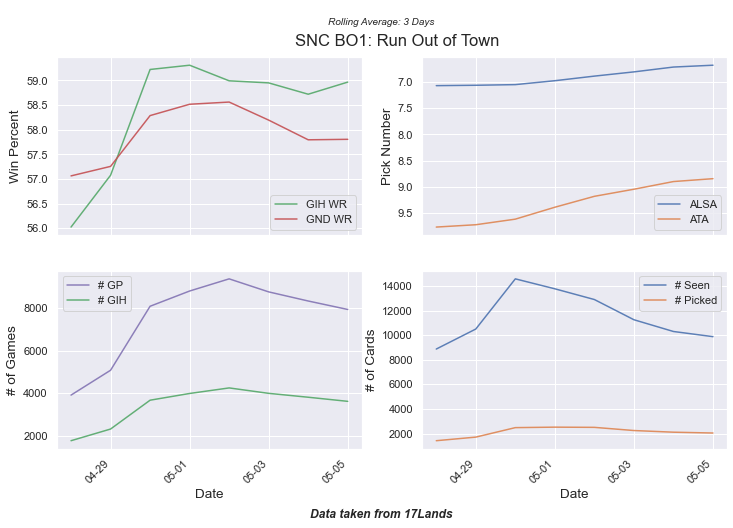

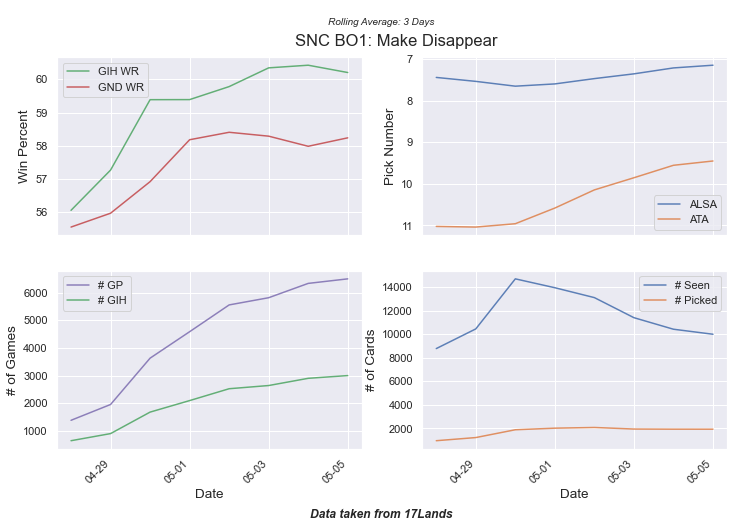

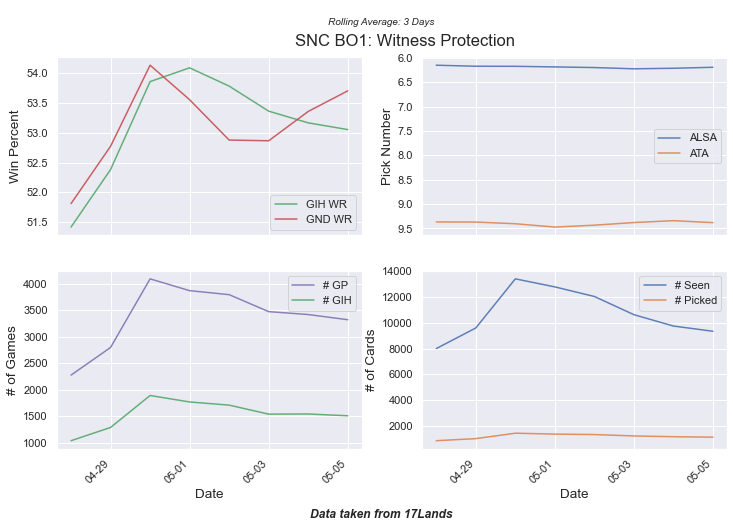

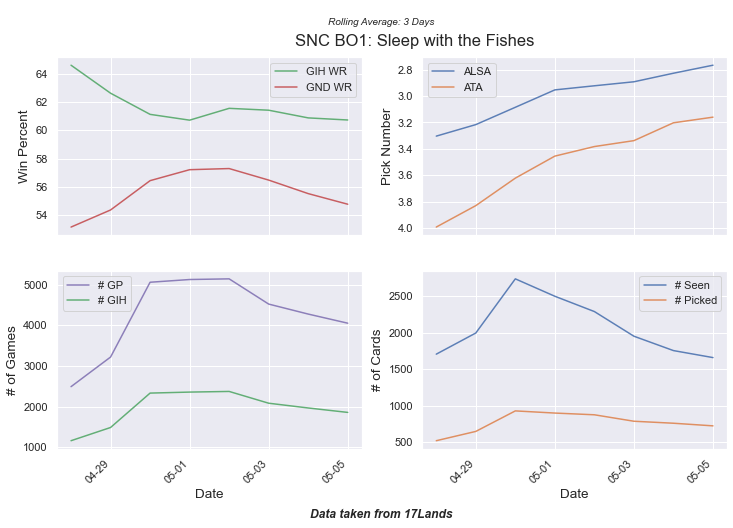

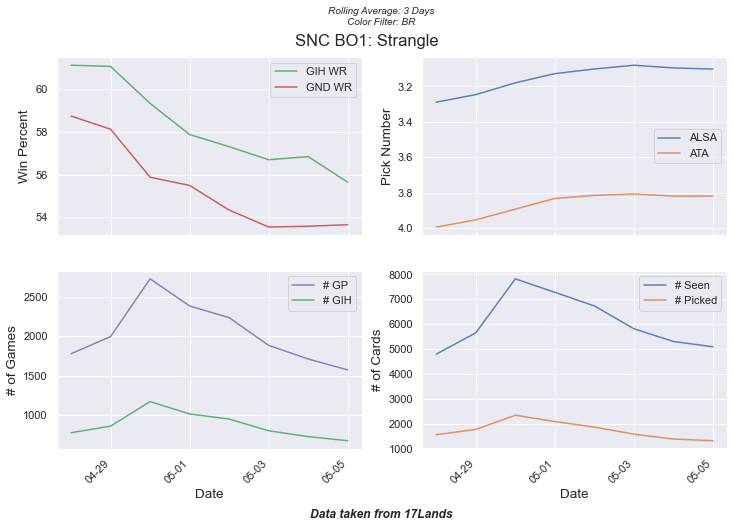

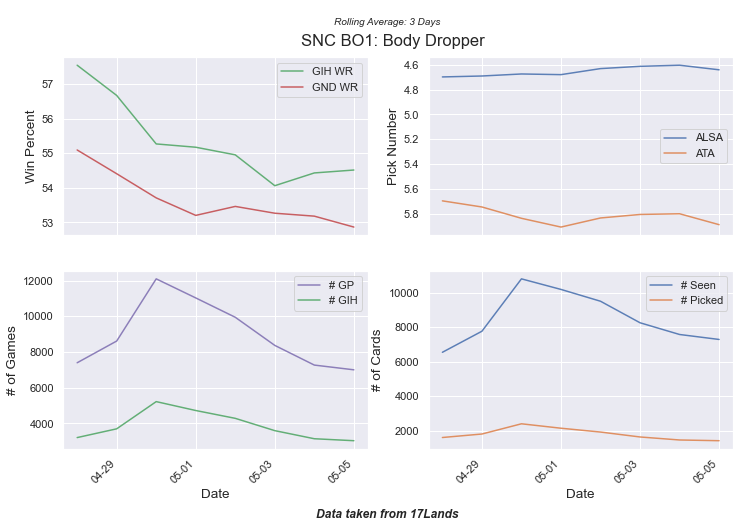

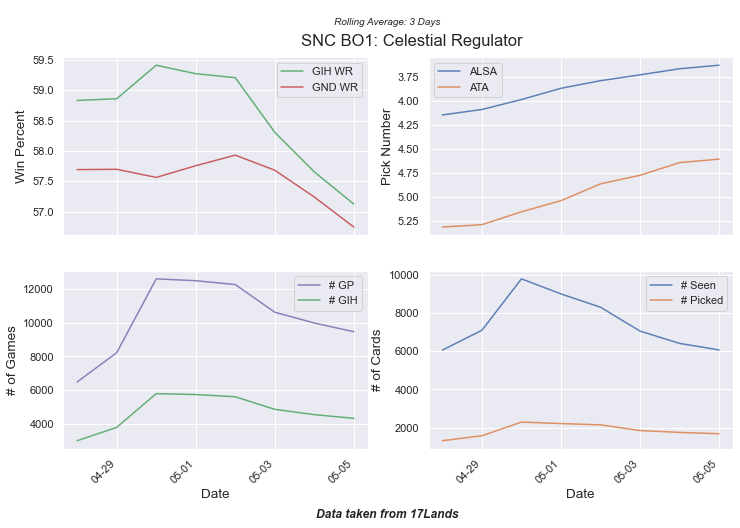

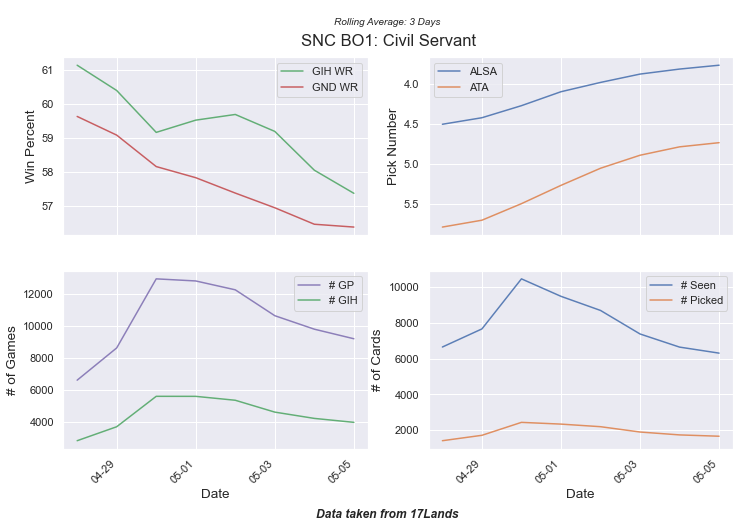

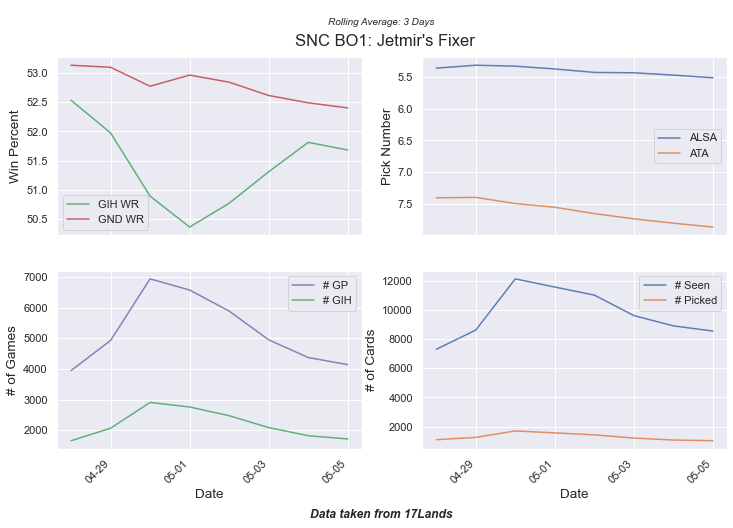

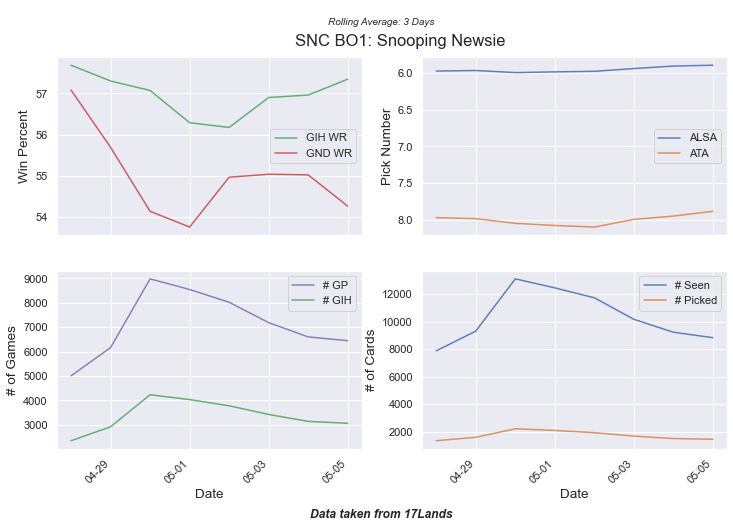

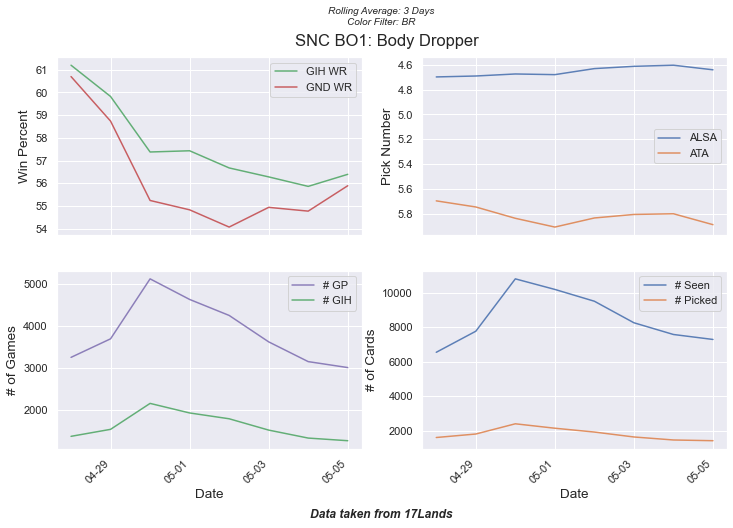

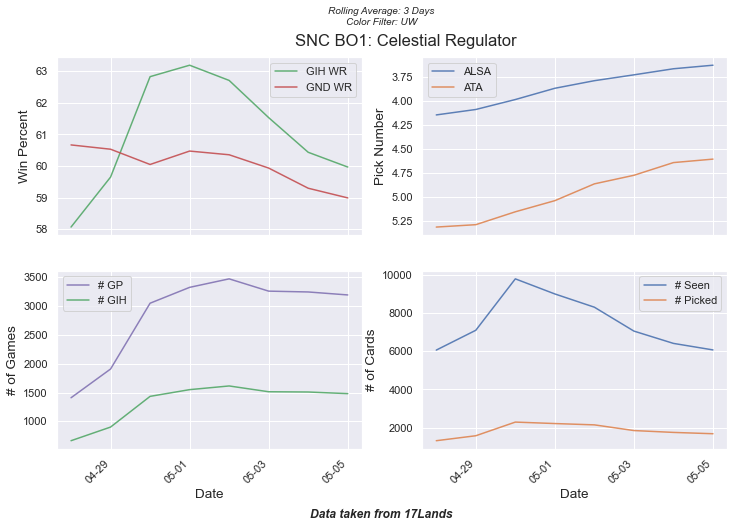

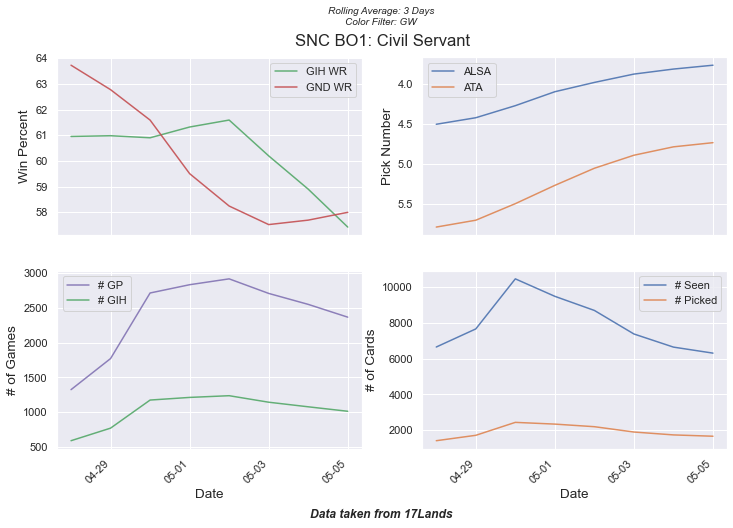

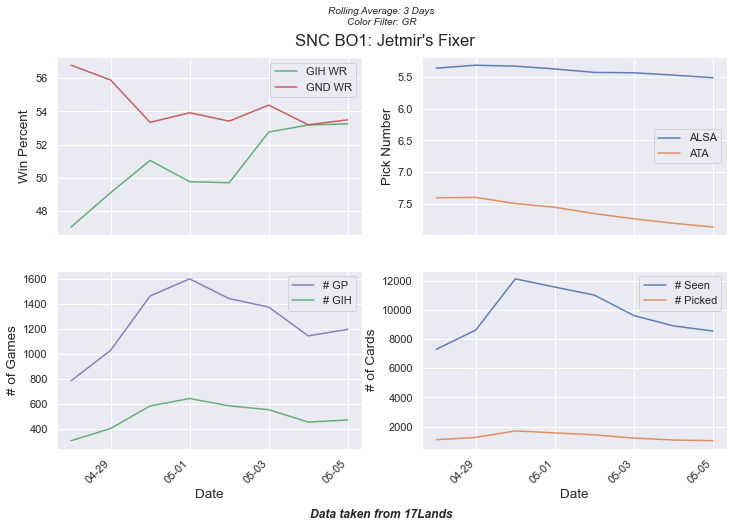

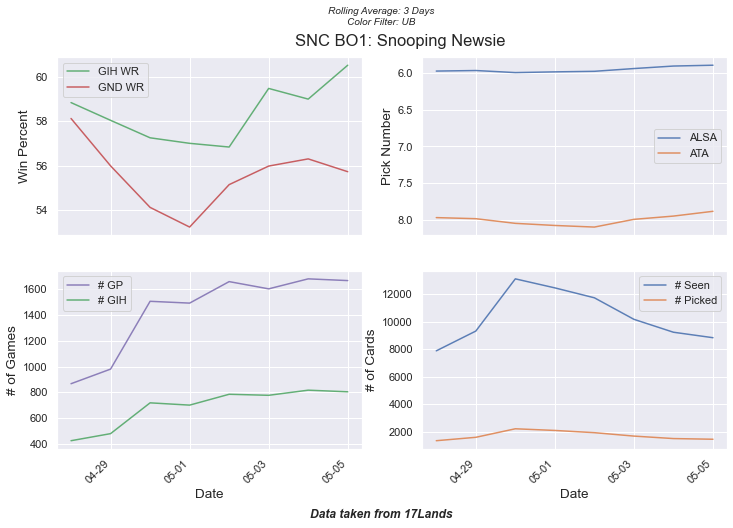

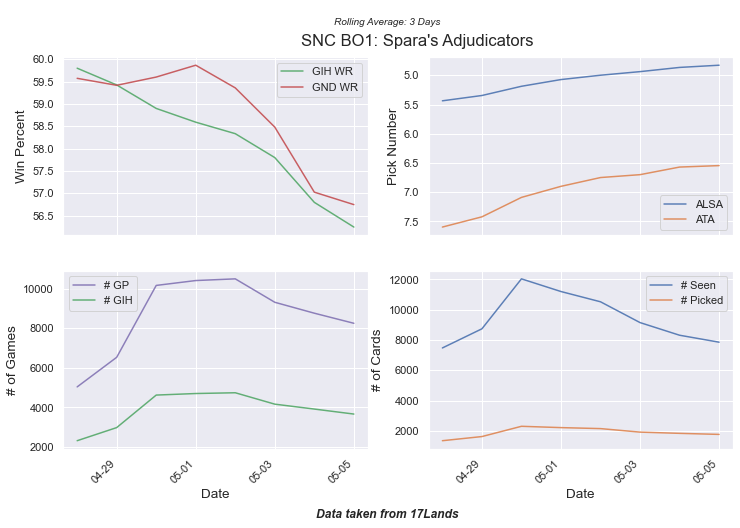

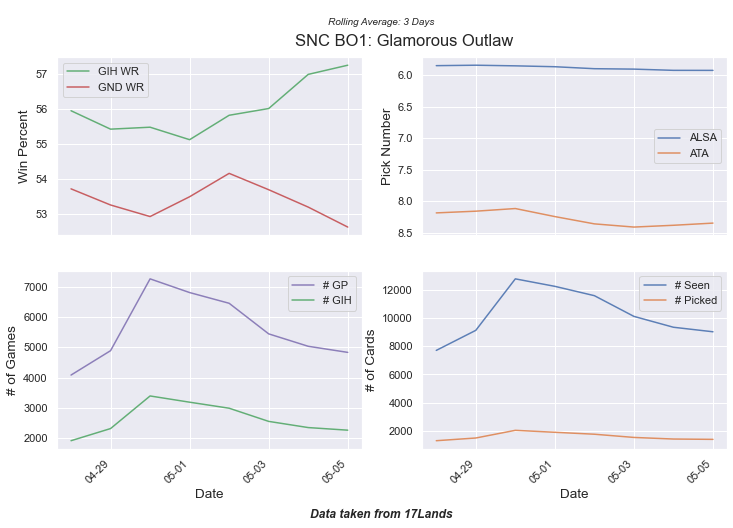

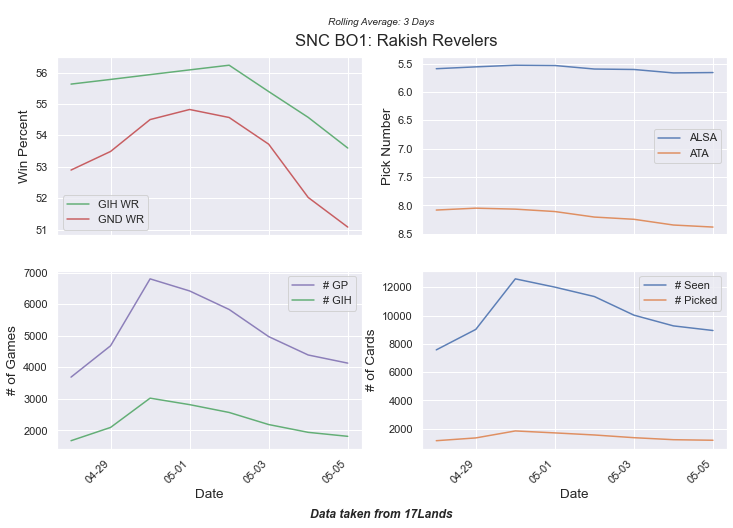

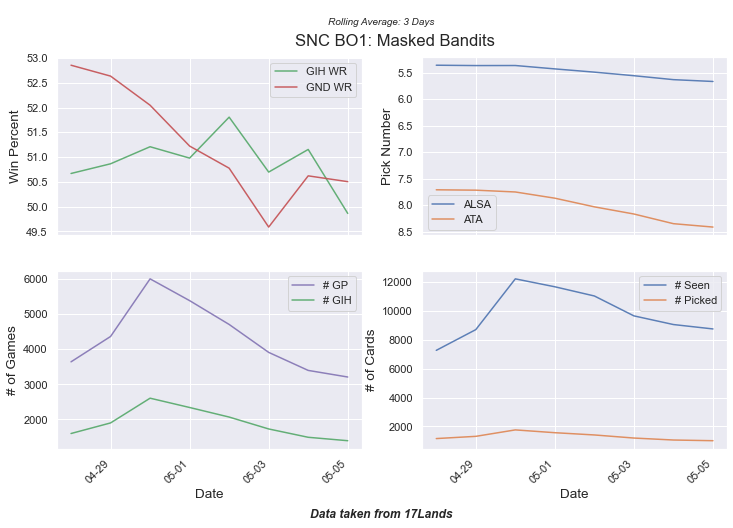

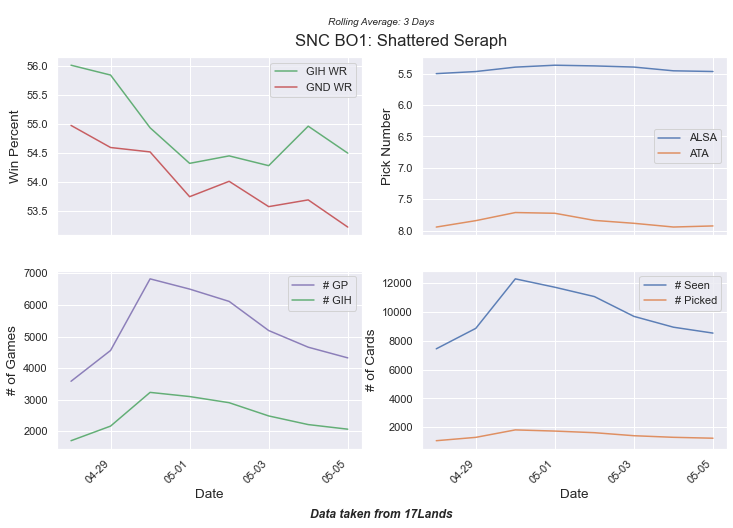

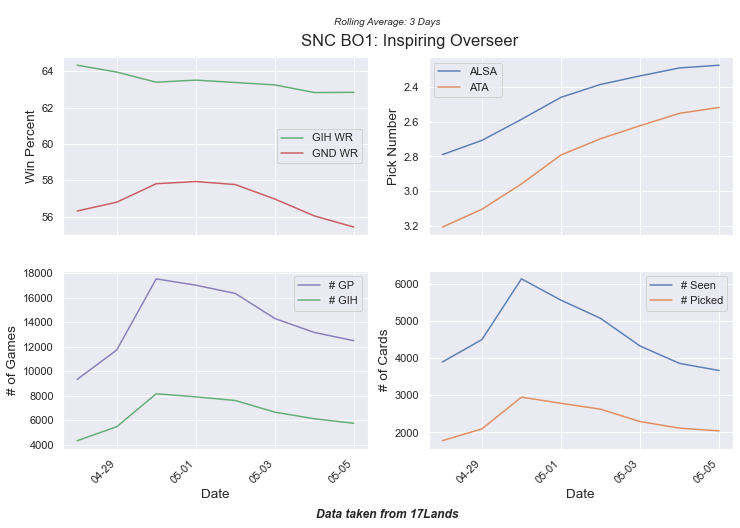

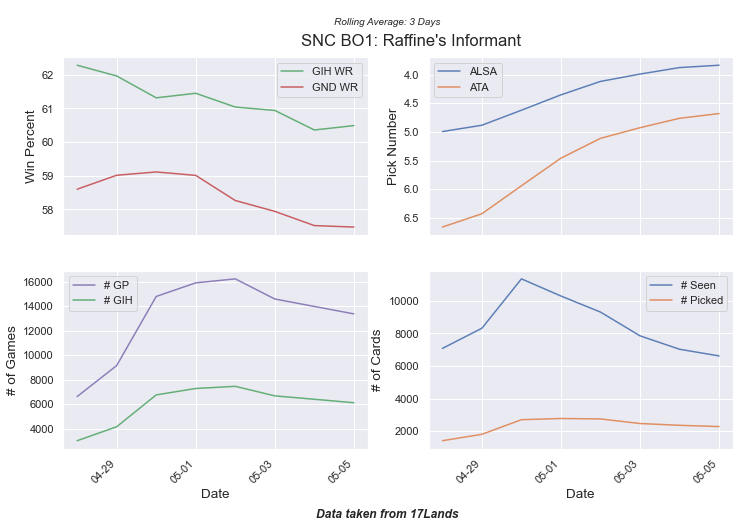

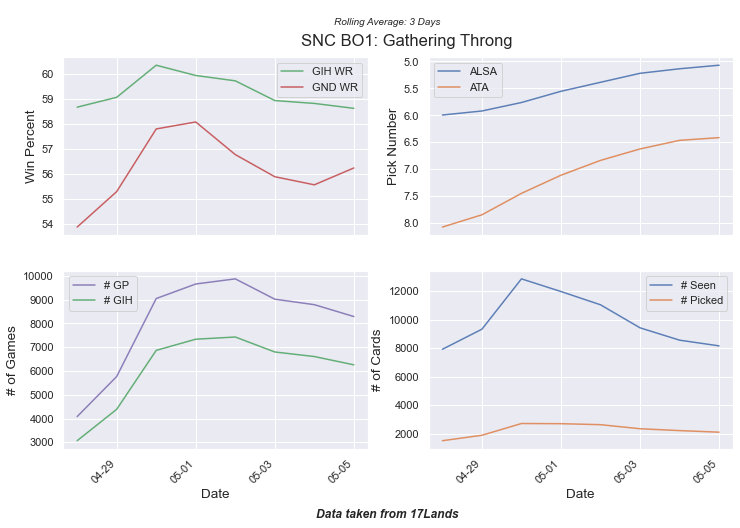

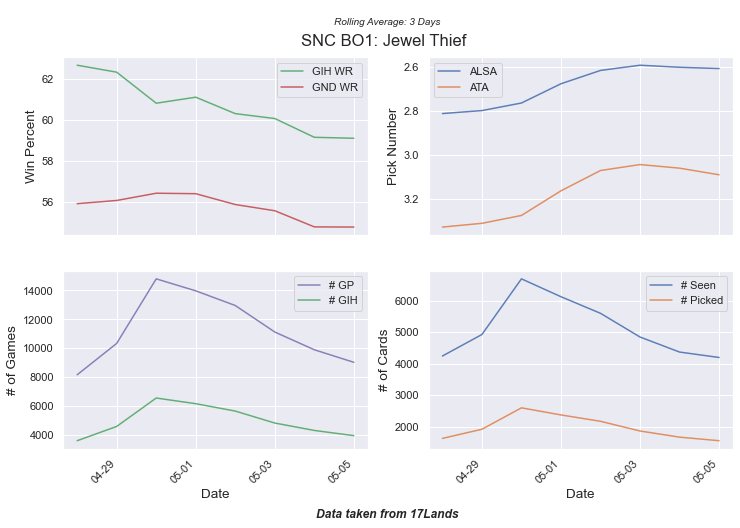

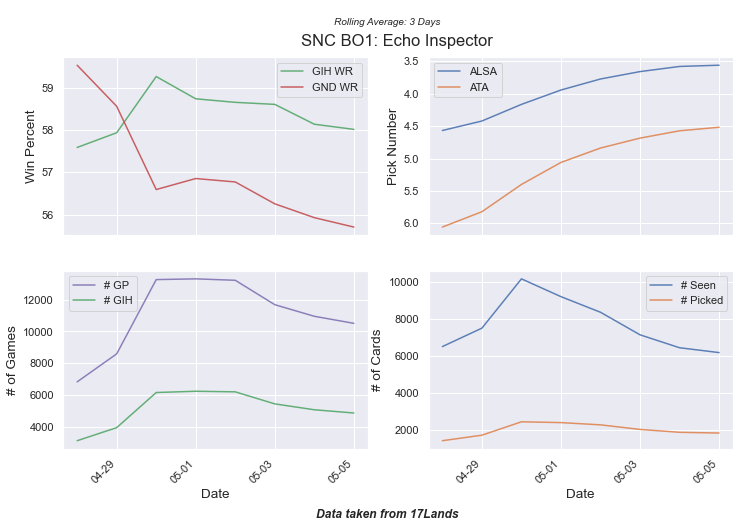

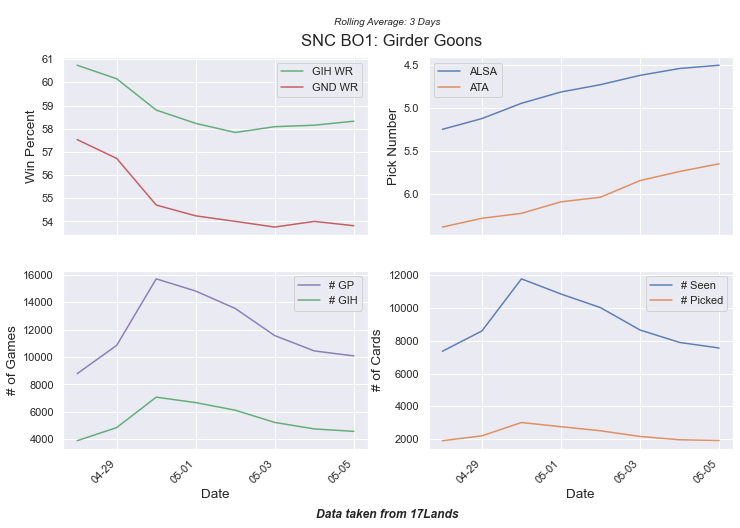

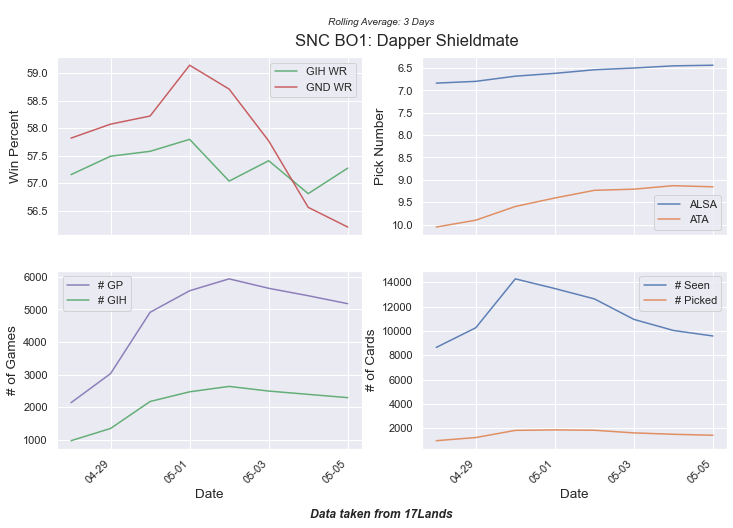

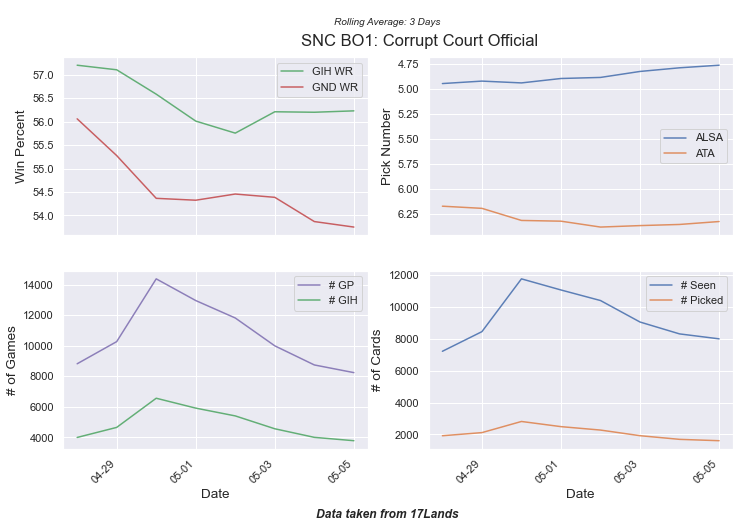

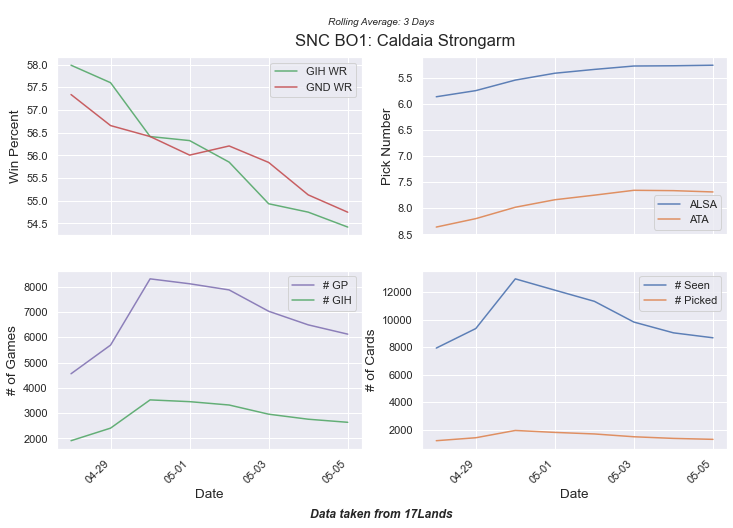

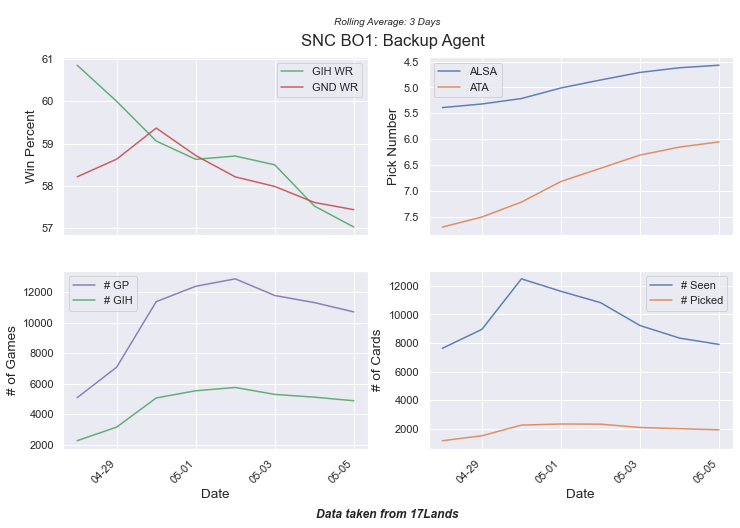

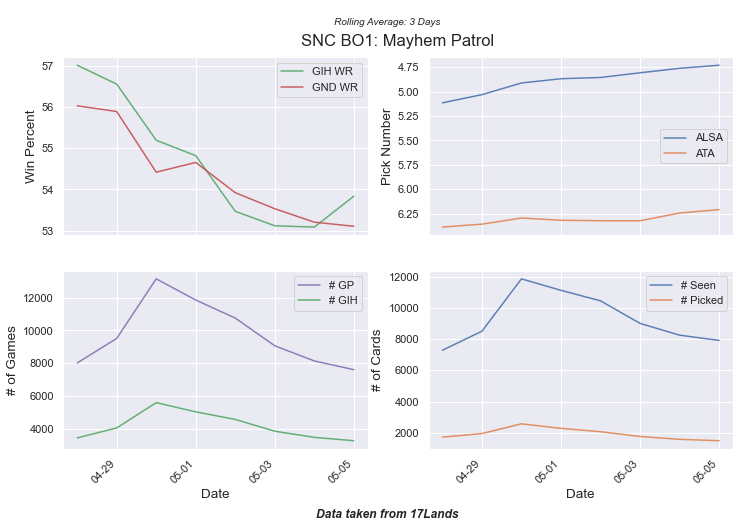

In [18]:
to_plot = [
    ('Murder', ''),
    ('Strangle', ''),
    ('Hold for Ransom', ''),
    ('Run Out of Town', ''),
    ('Make Disappear', ''),
    ('Witness Protection', ''),
    ('Sleep with the Fishes', ''),
    ('Strangle', 'BR'),
    ('Body Dropper', ''),
    ('Celestial Regulator', ''),
    ('Civil Servant', ''),
    ("Jetmir's Fixer", ''),
    ('Snooping Newsie', ''),
    ('Body Dropper', 'BR'),
    ('Celestial Regulator', 'UW'),
    ('Civil Servant', 'GW'),
    ("Jetmir's Fixer", 'GR'),
    ('Snooping Newsie', 'UB'),
    ("Spara's Adjudicators", ''),
    ('Glamorous Outlaw', ''),
    ('Rakish Revelers', ''),
    ('Masked Bandits', ''),
    ('Shattered Seraph', ''),
    ('Inspiring Overseer', ''),
    ("Raffine's Informant", ''),
    ('Gathering Throng', ''),
    ('Jewel Thief', ''),
    ('Echo Inspector', ''),
    ('Girder Goons', ''),
    ('Dapper Shieldmate', ''),
    ('Corrupt Court Official', ''),
    ('Caldaia Strongarm', ''),
    ('Backup Agent', ''),
    ('Mayhem Patrol', '')
]

for tup in to_plot:
    print(f"""Plotting "{tup[0]}"...""", end='')
    examiner.plot_card_summary(tup[0], colors=tup[1])
    print("     Done!")

## Card Pick Order Stats

In [ ]:
examiner.plot_pick_stats('Inspiring Overseer')

In [ ]:
examiner.plot_pick_stats('Inspiring Overseer', 3)

## Archetype Winrate History

In [19]:
prettify_frame(examiner.get_archetype_winrate_history(['ALL', '2C', '3C', 'WU', 'WG', 'UB', 'BR', 'RG', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG'], save=True))

Avg. Win %,ALL,2C,3C,WU,WG,UB,BR,RG,WUB,WUG,UBR,BRG,WRG
04-28,56.12,58.12,55.76,61.09,60.16,57.55,57.19,53.92,56.01,60.14,55.44,51.87,54.14
04-29,56.02,57.92,55.70,60.52,60.31,56.58,56.88,54.25,55.50,59.87,54.99,52.18,54.35
04-30,55.90,57.48,55.68,60.38,60.16,56.05,55.86,52.60,55.17,59.67,55.18,51.89,54.38
05-01,55.85,57.18,55.66,60.27,59.62,54.76,55.31,52.32,54.61,59.49,54.98,51.71,54.70
05-02,55.75,56.74,55.63,60.10,58.53,54.76,54.40,51.28,54.82,58.92,55.23,51.21,54.83
05-03,55.51,56.81,55.19,59.89,57.70,55.77,54.42,52.90,54.39,58.37,54.84,50.49,54.22
05-04,55.22,56.66,54.84,59.44,57.04,55.69,54.25,52.97,54.57,57.29,54.73,51.15,53.16
05-05,55.02,56.87,54.43,59.35,57.14,56.14,54.73,53.43,53.87,57.05,54.50,51.14,51.87


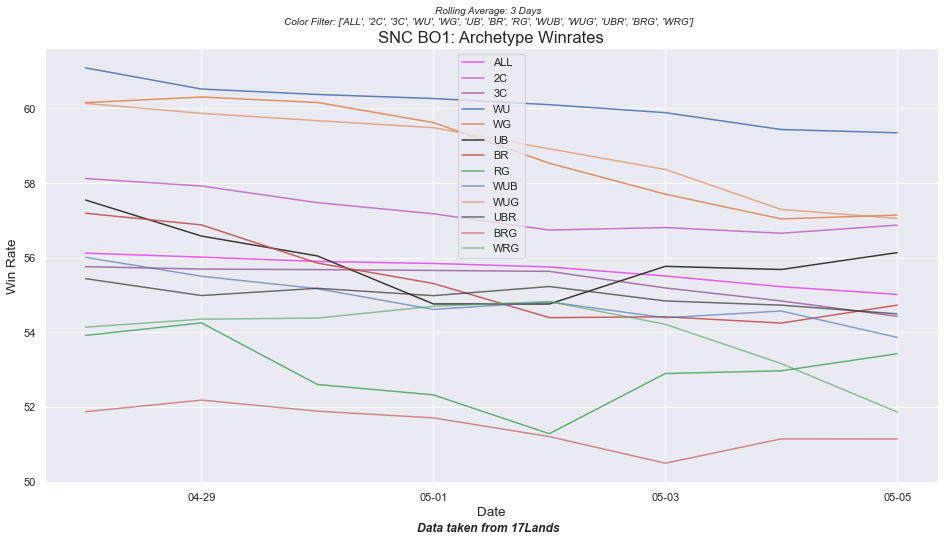

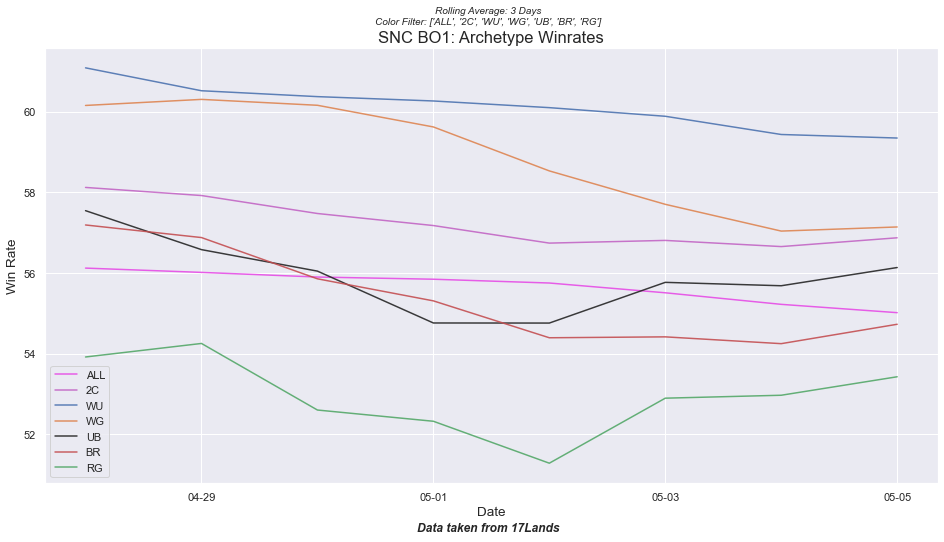

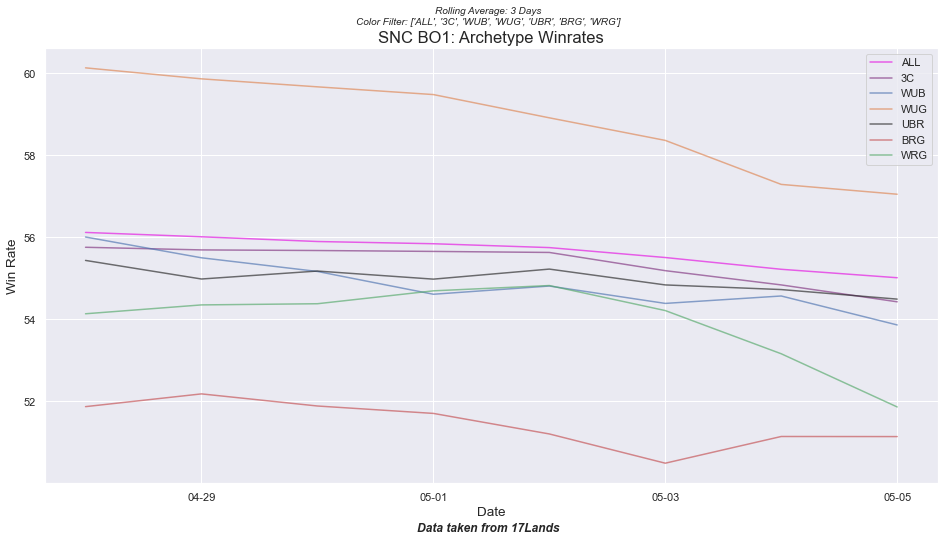

In [20]:
examiner.plot_archetype_winrate_history(['ALL', '2C', '3C', 'WU', 'WG', 'UB', 'BR', 'RG', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG'])
examiner.plot_archetype_winrate_history(['ALL', '2C', 'WU', 'WG', 'UB', 'BR', 'RG'], pref='2C')
examiner.plot_archetype_winrate_history(['ALL', '3C', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG'], pref='3C')

## Archetype Playrate History

In [21]:
prettify_frame(examiner.get_archetype_playrate_history(['2C', '3C', 'WU', 'WG', 'UB', 'BR', 'RG', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG'], save=True))

% of Decks,2C,3C,WU,WG,UB,BR,RG,WUB,WUG,UBR,BRG,WRG
04-28,25.23,68.96,4.64,4.19,2.98,9.47,2.99,13.82,16.39,13.03,12.74,12.55
04-29,25.09,69.35,5.46,4.39,2.76,8.53,3.03,13.76,17.66,12.56,12.32,12.66
04-30,25.45,69.17,6.21,4.73,2.74,8.01,2.82,13.95,18.77,12.31,11.59,12.21
05-01,26.67,68.36,7.43,5.26,2.74,7.45,2.86,13.72,20.29,11.76,10.78,11.51
05-02,28.22,67.15,8.60,5.71,3.02,7.28,2.66,13.55,21.09,11.43,9.86,10.94
05-03,29.87,65.81,9.51,6.07,3.27,7.15,2.93,13.16,21.47,11.25,9.22,10.43
05-04,31.13,64.80,10.67,6.22,3.52,6.92,2.82,12.72,21.97,11.17,8.66,10.05
05-05,31.85,64.16,10.96,6.34,3.59,6.94,3.05,12.50,22.17,11.31,8.52,9.47


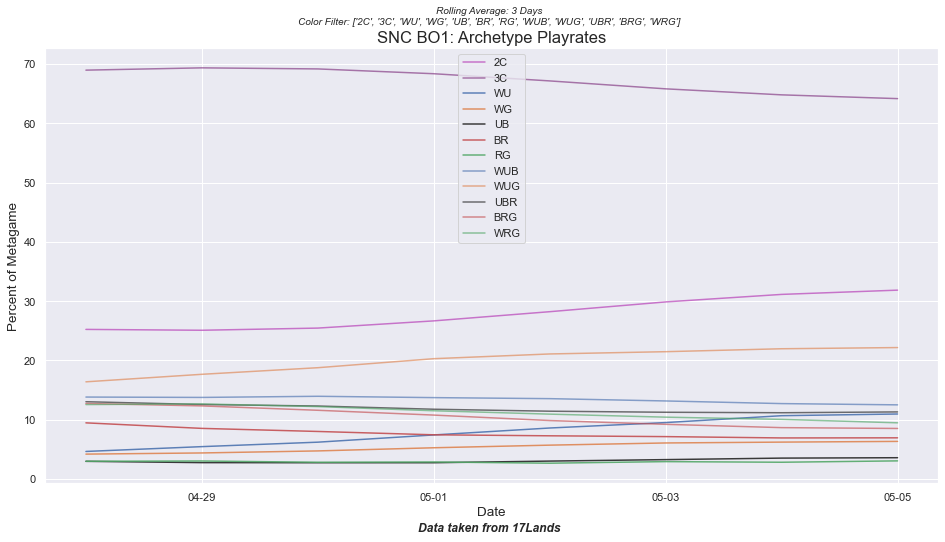

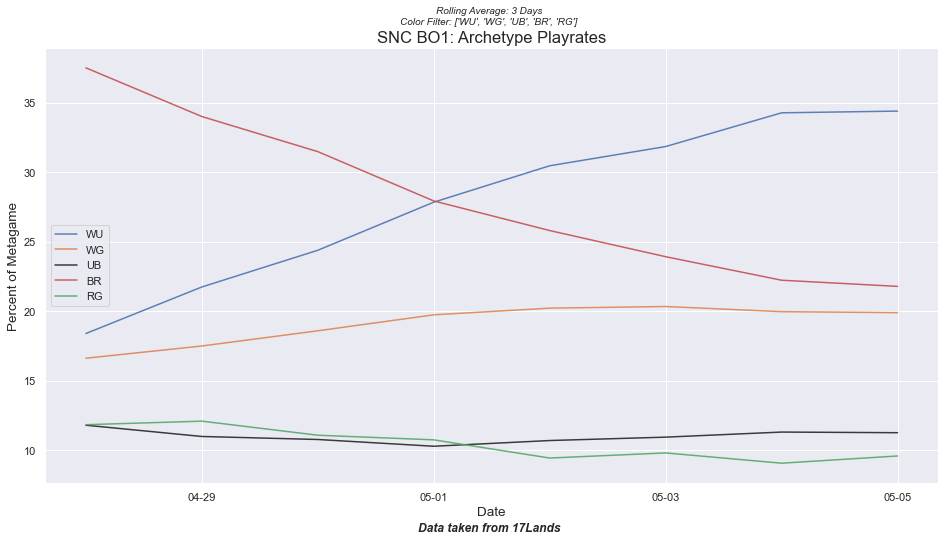

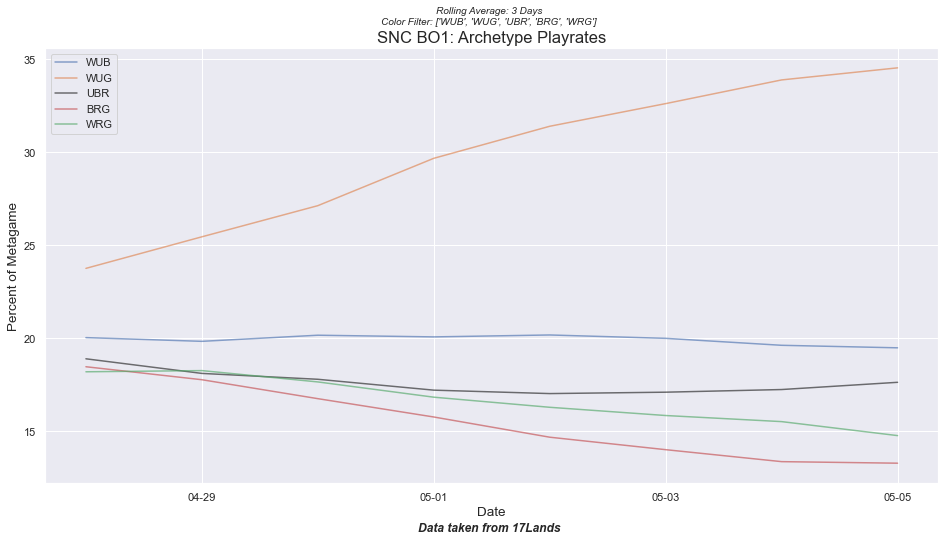

In [22]:
examiner.plot_archetype_playrate_history(['2C', '3C', 'WU', 'WG', 'UB', 'BR', 'RG', 'WUB', 'WUG', 'UBR', 'BRG', 'WRG'])
examiner.plot_archetype_playrate_history(['WU', 'WG', 'UB', 'BR', 'RG'], 2, pref='2C')
examiner.plot_archetype_playrate_history(['WUB', 'WUG', 'UBR', 'BRG', 'WRG'], 3, pref='3C')

## Card Pick Order Changes

In [33]:
#TODO: Merge all of this functionality into one structure.
helper = PlotterHelper(examiner.DATA)
diff = examiner.compare_card_evaluations('2022-04-28', '2022-05-05')
commons = diff[diff['Rarity'] == 'C']
uncommons = diff[diff['Rarity'] == 'U']
SRT_TRG = 'ATA Change'

In [34]:
frame = commons.sort_values(SRT_TRG, ascending=False).head(20)
helper.frame_to_png(frame, "HigherTakenCommons.png")

,ALSA,ALSA Change,ATA,ATA Change,Color,Rarity
Raffine's Informant,3.76,1.31,4.58,2.23,W,C
Gathering Throng,5.07,0.96,6.37,1.91,W,C
Echo Inspector,3.53,1.18,4.47,1.81,U,C
Sky Crier,5.09,0.87,7.02,1.73,W,C
Backup Agent,4.55,0.80,6.03,1.69,W,C
Make Disappear,7.00,0.30,9.18,1.66,U,C
Quick-Draw Dagger,6.48,1.00,8.88,1.59,,C
Spara's Adjudicators,4.79,0.73,6.43,1.38,WUG,C
Security Bypass,7.46,0.21,10.82,1.29,U,C
Civil Servant,3.73,0.83,4.67,1.25,WG,C


In [35]:
frame = commons.sort_values(SRT_TRG, ascending=True).head(20)
helper.frame_to_png(frame, "LowerTakenCommons.png")

,ALSA,ALSA Change,ATA,ATA Change,Color,Rarity
Goldhound,6.28,-0.69,9.22,-1.49,R,C
Incriminate,8.21,-1.39,12.28,-1.24,B,C
Big Score,7.08,-0.71,10.58,-1.21,R,C
Paragon of Modernity,6.63,-0.43,10.33,-1.05,,C
Demon's Due,8.22,-0.78,11.85,-0.82,B,C
Join the Maestros,7.06,-0.43,10.51,-0.78,B,C
Midnight Assassin,6.11,-0.42,9.22,-0.76,B,C
Maestros Theater,5.48,-0.11,7.75,-0.75,,C
Riveteers Overlook,5.42,0.00,7.89,-0.67,,C
Maestros Initiate,6.61,-0.15,9.69,-0.66,UBR,C


In [36]:
frame = uncommons.sort_values(SRT_TRG, ascending=False).head(10)
helper.frame_to_png(frame, "HigherTakenUncommons.png")

,ALSA,ALSA Change,ATA,ATA Change,Color,Rarity
Psychic Pickpocket,2.58,1.02,2.91,1.39,U,U
Hypnotic Grifter,4.05,0.92,5.40,1.36,U,U
Luxurious Libation,3.65,0.69,4.71,1.25,G,U
Out of the Way,3.74,0.90,4.52,1.22,U,U
Illuminator Virtuoso,3.17,0.69,3.66,1.15,W,U
Sleep with the Fishes,2.68,0.66,3.02,1.04,U,U
Take to the Streets,6.21,0.27,9.00,0.98,G,U
Ceremonial Groundbreaker,4.38,0.63,5.80,0.97,WG,U
Voice of the Vermin,2.99,0.56,3.53,0.94,G,U
Knockout Blow,2.95,0.57,3.65,0.82,W,U


In [37]:
frame = uncommons.sort_values(SRT_TRG, ascending=True).head(10)
helper.frame_to_png(frame, "LowerTakenUncommons.png")

,ALSA,ALSA Change,ATA,ATA Change,Color,Rarity
Riveteers Charm,4.32,-0.46,6.24,-1.76,BRG,U
"Mr. Orfeo, the Boulder",4.24,-0.44,5.72,-1.50,BRG,U
Vampire Scrivener,6.41,-0.94,9.63,-1.39,B,U
Forge Boss,4.47,-0.50,5.85,-1.32,BR,U
Scuttling Butler,6.27,-0.88,9.31,-1.25,,U
Arc Spitter,8.08,-0.82,11.96,-1.11,,U
Glittering Stockpile,7.64,-1.16,11.60,-1.02,R,U
Crew Captain,5.40,-0.46,8.35,-0.96,BRG,U
Unlucky Witness,4.95,-0.23,6.86,-0.90,R,U
Tainted Indulgence,5.34,-0.34,7.65,-0.89,UB,U
